# Setup

In [29]:
# Import several packages that will be used throughout

# numeric packages
import numpy as np
import scipy
import scipy.io
import pandas as pd
import h5py

# filesystem and OS
import sys, os, time
import glob

# plotting
from matplotlib import pyplot as plt
import matplotlib
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : False})
from IPython.display import clear_output

import warnings
warnings.filterwarnings('ignore')

# these magics ensure that external modules that are modified are also automatically reloaded
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import keras
import tensorflow as tf

Using TensorFlow backend.


In [3]:
sys.path.append("/home/adalbert/nbserver/satsense/keras-models/")
import keras_utils as ku

In [4]:
workdir = "/home/adalbert/nbserver/tf-workspace/urban-atlas-experiments/"

if not os.path.exists(workdir):
	os.makedirs(workdir)
    
os.chdir(workdir)

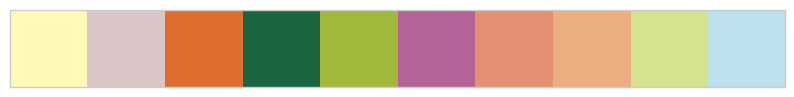

In [89]:
import gzip
import cPickle as pickle 

with gzip.open("classes.pickle.gz", "r") as f:
    dict_classes = pickle.load(f)
    
class2label = dict_classes["class2label"]
label2class = dict_classes["label2class"]
classes = class2label.keys()

N_CLASSES = len(classes)

class_colors_rgb = [
    ('Continuous Urban Fabric (S.L. > 80%)', (102, 48, 52)),
    ('Discontinuous Dense Urban Fabric (S.L. : 50% -  80%)', (167, 40, 49)),
    ('Discontinuous Medium Density Urban Fabric (S.L. : 30% - 50%)', (218, 96, 75)),
    ('Discontinuous Low Density Urban Fabric (S.L. : 10% - 30%)', (229, 144, 117)),
    ('Discontinuous Very Low Density Urban Fabric (S.L. < 10%)', (249, 171, 174)),
    ('Isolated Structures', (184, 117, 98)),
    ('Industrial, commercial, public, military and private units', (179, 99, 149)),
    ('Fast transit roads and associated land', (221, 110, 47)),
    ('Other roads and associated land', (236, 174, 128)),
    ('Railways and associated land', (119, 119, 118)),
    ('Port areas', (215, 187, 208)), 
    ('Airports', (218, 198, 199)),
    ('Mineral extraction and dump sites', (135, 100, 83)),
    ('Construction sites', (193, 161, 113)),
    ('Land without current use', (134, 88, 79)),
    ('Green urban areas', (161, 185, 59)),
    ('Sports and leisure facilities', (214, 227, 140)), 
    ('Agricultural + Semi-natural areas + Wetlands', (255, 250, 182)),
    ('Forests', (25, 101, 64)),
    ('Water bodies', (189, 225, 237)),
    ('Not Classified', (203, 204, 203))
]
class_colors_all = {c:(np.array(v)/float(255)).tolist() + [1.0] for c,v in class_colors_rgb}

consolidate_classes = {
#     "Continuous Urban Fabric (S.L. > 80%)":"High Density Urban Fabric",
#      "Discontinuous Dense Urban Fabric (S.L. : 50% -  80%)":"High Density Urban Fabric",
     "Discontinuous Medium Density Urban Fabric (S.L. : 30% - 50%)":"Low Density Urban Fabric",
     "Discontinuous Low Density Urban Fabric (S.L. : 10% - 30%)":"Low Density Urban Fabric",
     "Discontinuous Very Low Density Urban Fabric (S.L. < 10%)":"Low Density Urban Fabric"
}
classes_consolidate = {v:[x for x in consolidate_classes.keys() if consolidate_classes[x] == v] \
                       for k,v in consolidate_classes.iteritems()}

label_colors = {i:class_colors_all[classes_consolidate[label2class[i]][1] \
                                   if label2class[i] in classes_consolidate else label2class[i]] \
                for i in range(N_CLASSES)}
class_colors = {c:class_colors_all[classes_consolidate[c][1] if c in classes_consolidate else c] \
                for c,i in class2label.iteritems()}

cmap = matplotlib.colors.ListedColormap([class_colors[c] for c in classes])

sns.palplot(sns.color_palette([v for c, v in label_colors.iteritems()]))

In [47]:
ckeys

(0, 1, 2, 3, 4, 5, 6, 7, 8, 9)

In [75]:
cities = ["athina", "berlin", "bucuresti", "tallinn", "barcelona", "dublin"]

palette_cities = dict(zip(cities, sns.color_palette("hls", len(cities))))

cmap_city = matplotlib.colors.ListedColormap(palette_cities.values())

# Load pretrained model and extract features

#### Load pretrained model

In [5]:
model_file = "./resnet50-urbanatlas-athina+berlin+bucuresti+tallinn+barcelona+dublin-0.73-checkpoint.h5"

# with tf.device('/cpu:0'):
# load model and weights
model = keras.models.load_model(model_file)

# compile model
from keras.optimizers import Adadelta
model.compile(loss='categorical_crossentropy', \
              metrics=['accuracy'],\
              optimizer=Adadelta(lr=0.01))


In [6]:
model.layers[-1].name

u'dense_1'

#### Load & preprocess data, use model to extract features

In [7]:
# extract activations for a batch of images

from keras import backend as K

def get_activations(model, layer_id, X_batch):
    layer_dict = {l.name:l for l in model.layers}
    if type(layer_id) is str:
        feat_layer = layer_dict[layer_id]
    else:
        feat_layer = model.layers[layer_id]
    fn_activations = K.function([model.layers[0].input, K.learning_phase()], \
                                 [feat_layer.output,])
    activations = fn_activations([X_batch,0])[0]
    return activations


# extract features 

def extract_features(model, sources, batch_size=100, layer=None):
    n_chunks = int(np.ceil(len(sources) / batch_size))
    chunks = np.array_split(sources, n_chunks)
    features = []
    for idx, chunk in enumerate(chunks):
        clear_output(wait=True)
        print "Chunk %d / %d" % (idx, n_chunks)
        batch = []
        for s in chunk:
            filename, label = s
            img = ku.load_and_preprocess(filename) * 1.0/255.0
            batch.append(img)
        batch = np.array(batch)
        if layer is None:
            pred = model.predict(batch)
        else:
            pred = get_activations(model, layer, batch)
        features.append(pred)
    features = np.vstack(features)
    return features

In [8]:
files_df = pd.read_csv("./athina+berlin+bucuresti+tallinn+barcelona+dublin-test.csv")
files_df.shape

(28456, 4)

In [9]:
files_df = files_df.groupby("city").apply(lambda df: ku.balanced_df(df, nrows=1000))

In [10]:
sources = zip(files_df['filename'].values, files_df['class'].values)
features = extract_features(model, sources, layer="dense_1")

Chunk 59 / 60


In [14]:
features = np.vstack(features)

In [15]:
features.shape

(6000, 10)

In [16]:
np.savez_compressed("features_batch.npz", features)

# Clustering using extracted features

In [17]:
# https://github.com/DmitryUlyanov/Multicore-TSNE

from MulticoreTSNE import MulticoreTSNE as TSNE

tsne = TSNE(n_jobs=32, perplexity=20)
feats_tsne = tsne.fit_transform(features.astype(np.float64))

In [91]:
import seaborn as sns
import matplotlib.patheffects as PathEffects

def labeled_scatterplot(x, labels, palette=None, ax=None, add_text=True):
    
    classes = np.unique(labels)
    class_dict = {c:i for i,c in enumerate(classes)}
    n_clust = len(classes)    
    colors = [palette[l] for l in labels]

    # We create a scatter plot.
    if ax is None:
        f = plt.figure(figsize=(8, 8))
        ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40, c=colors)
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    if add_text:
        # We add the labels for each class.
        txts = []
        for k,c in enumerate(classes):
            # Position of each label.
            xtext, ytext = np.median(x[labels == c, :], axis=0)
            txt = ax.text(xtext, ytext, str(c), fontsize=24)
            txt.set_path_effects([
                PathEffects.Stroke(linewidth=5, foreground=palette[c]),
                PathEffects.Normal()])
            txts.append(txt)

    return ax

In [92]:
import re
import abbreviate
abbr = abbreviate.Abbreviate()

def split_str(s):
    s = re.sub('[^A-Za-z0-9% ]+', '', s)
    words = s.split(" ")
    words = [abbr.abbreviate(w, target_len=10).capitalize() for w in words]
    if len(words)==1:
        return s #+ "\n"
    if len(words)>4:
        words = words[:3] + [words[-1]]
    else:
        words = words[:4]
    return " ".join(words[:(len(words)/2)]) + "\n" + " ".join(words[(len(words)/2):])


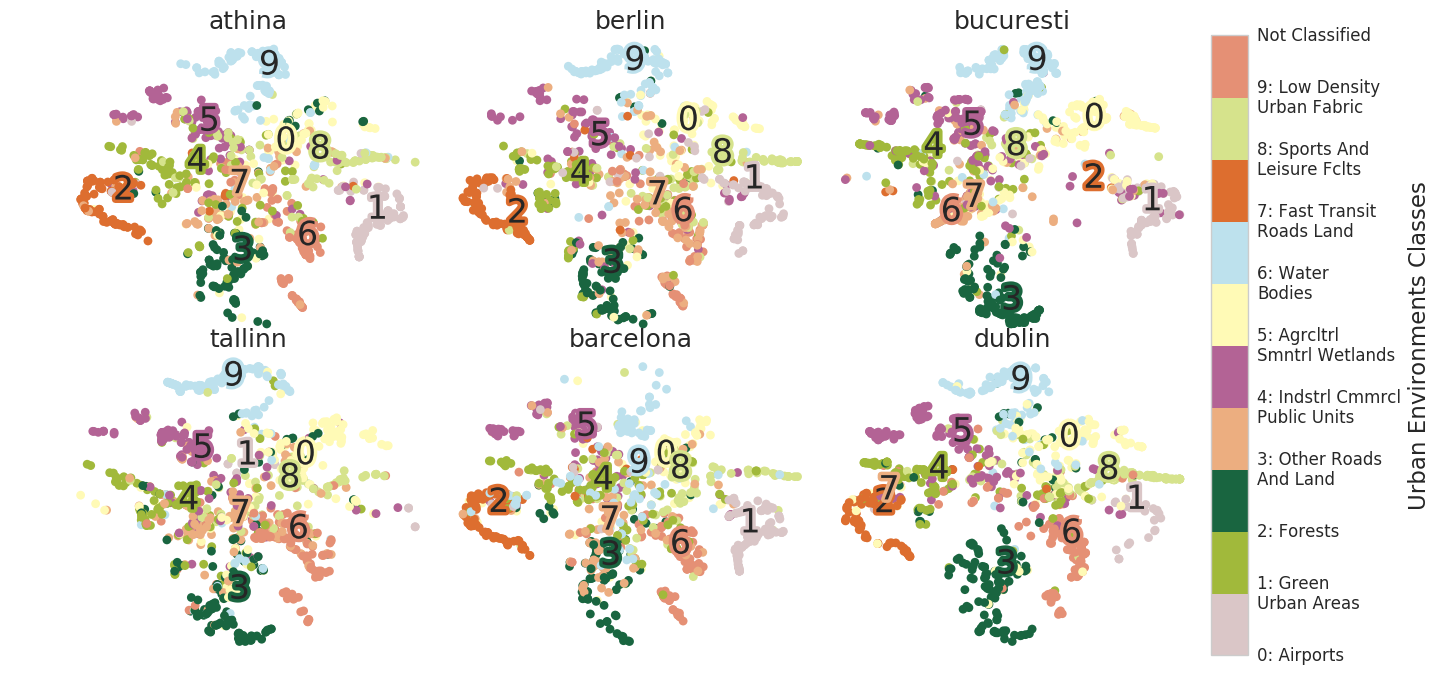

In [93]:
# embeddings plot over cities

sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 1})

plt.figure(figsize=(30,8))
width_ratios = [10 for _ in range(len(cities)/2)] + [1] + [10 for _ in range(len(cities)/2)] + [1]
gs = matplotlib.gridspec.GridSpec(2, len(cities)/2+1, width_ratios=width_ratios, wspace=0.025, hspace=0.05)
ax_cbar = plt.subplot(gs[:,-1])

myticks = range(N_CLASSES) + [10]
myticklabels = [split_str(c) for c in classes] + ["Not Classified"]
myticklabels = ["%d: %s"%(i,split_str(c)) for i,c in enumerate(classes)] + ["Not Classified"]

cb3 = matplotlib.colorbar.ColorbarBase(ax_cbar, cmap=cmap,
                                boundaries=myticks,
                                ticks=myticks,
                                orientation="vertical",
                                ticklocation="right",
                                spacing='uniform')
cb3.set_label('Urban Environments Classes')
cb3.ax.set_yticks(myticks)
cb3.ax.set_yticklabels(myticklabels, fontsize=12)

for n,c in enumerate(cities):
    i = n / 3; j = n % 3
    ax = plt.subplot(gs[i,j])
    idx = files_df['city']==c
    labels = files_df[idx]['class'].apply(lambda x: class2label[x])
    ax = labeled_scatterplot(feats_tsne[idx,:], labels, ax=ax, palette=label_colors)
    ax.set_title(c)

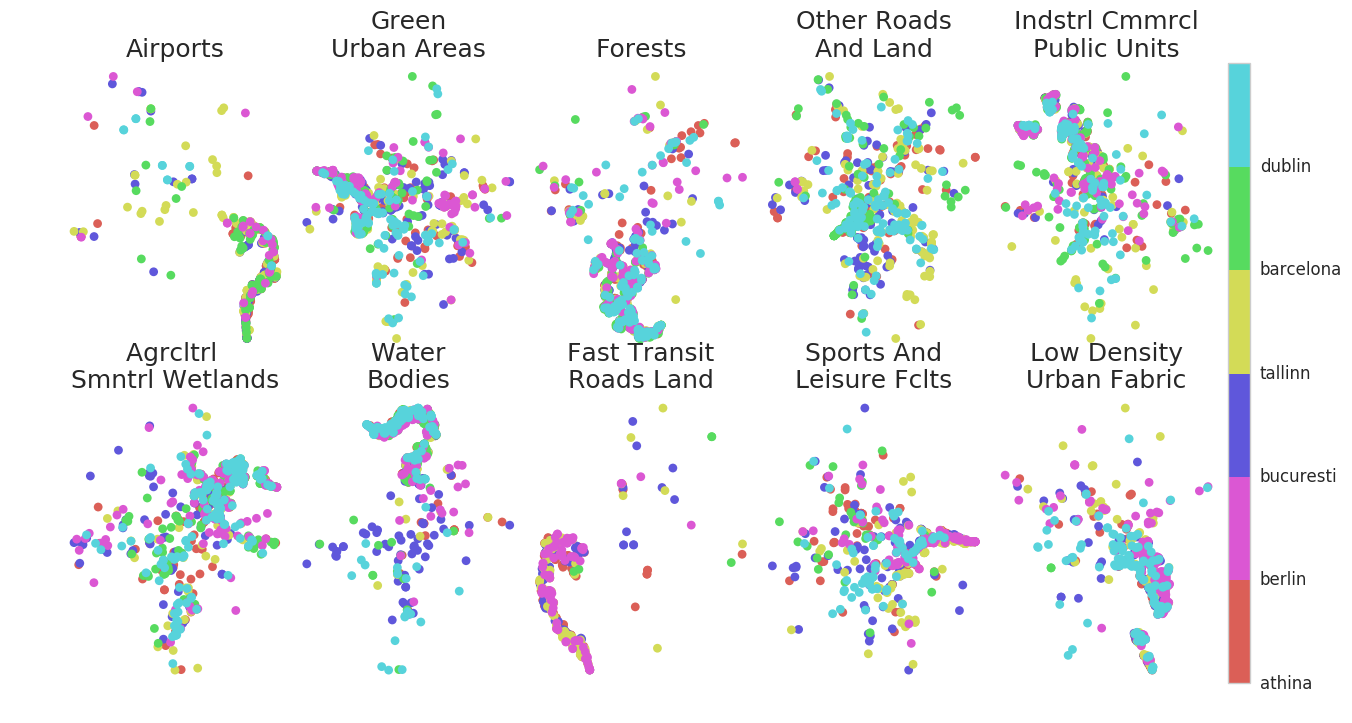

In [87]:
# embeddings plot over classes

sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 1})

plt.figure(figsize=(30,8))
width_ratios = [10 for _ in range(len(classes)/2)] + [1] + [10 for _ in range(len(classes)/2)] + [1]
gs = matplotlib.gridspec.GridSpec(2, len(classes)/2+1, width_ratios=width_ratios, wspace=0.025, hspace=0.15)
ax_cbar = plt.subplot(gs[:,-1])

myticks = range(len(cities))
myticklabels = cities

cb3 = matplotlib.colorbar.ColorbarBase(ax_cbar, cmap=cmap_city,
                                boundaries=myticks + [len(cities)],
                                ticks=myticks,
                                orientation="vertical",
                                ticklocation="right",
                                spacing='uniform')
cb3.ax.set_yticks(myticks)
cb3.ax.set_yticklabels(myticklabels, fontsize=12)
city_label = {c:i for i,c in enumerate(cities)}

for n,c in enumerate(classes):
    i = n / 5; j = n % 5
    ax = plt.subplot(gs[i,j])
    idx = files_df['class']==c
    labels = files_df[idx]['city'].values #.apply(lambda x: city_label[x])
    ax = labeled_scatterplot(feats_tsne[idx,:], labels, ax=ax, palette=palette_cities, add_text=False)
    ax.set_title(split_str(c))

In [78]:
palette_cities

{'athina': (0.86, 0.37119999999999997, 0.33999999999999997),
 'barcelona': (0.37119999999999997, 0.33999999999999997, 0.86),
 'berlin': (0.82879999999999987, 0.86, 0.33999999999999997),
 'bucuresti': (0.33999999999999997, 0.86, 0.37119999999999997),
 'dublin': (0.86, 0.33999999999999997, 0.82879999999999987),
 'tallinn': (0.33999999999999997, 0.82879999999999987, 0.86)}

(<matplotlib.figure.Figure at 0x7f7f29975650>,
  <matplotlib.text.Text at 0x7f7f28f19ed0>])

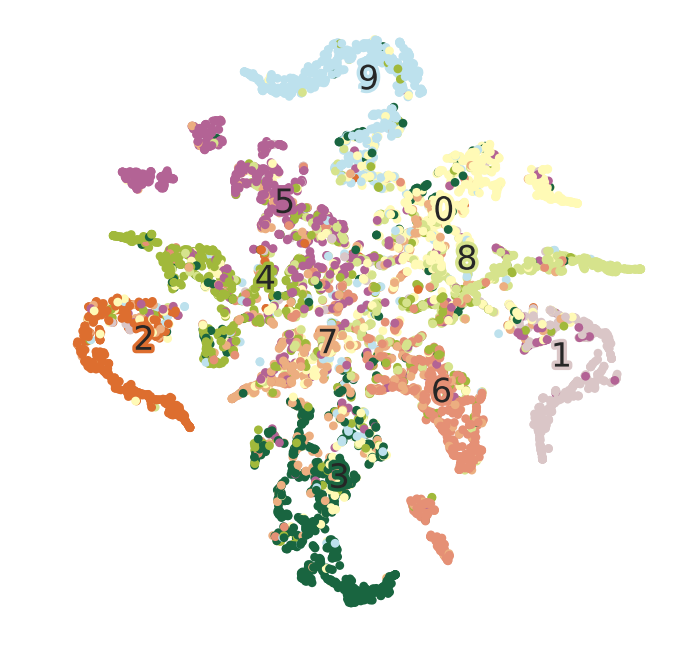

In [40]:
labeled_scatterplot(feats_tsne, labels, palette=label_colors)